<a href="https://colab.research.google.com/github/HSKrab/data-course-sample/blob/main/sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [205]:
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta

# Sample Code

## 基礎建設

In [206]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [207]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2021-12-27 01:32:01--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv.5’

All_Beauty.csv.5    100%[===================>]  14.78M  19.8MB/s    in 0.7s    

2021-12-27 01:32:02 (19.8 MB/s) - ‘All_Beauty.csv.5’ saved [15499476/15499476]

--2021-12-27 01:32:02--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz.5’

meta_All_Beauty.jso 100%[===================>]   9.85M  15.1MB/s    in 0.7s   

In [208]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [209]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [210]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [211]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

## 資料切分

In [212]:
def cut(predict,ratings=ratings):
  """
  let predict be the first day of any month.
  """
  train = ratings[
    (ratings['DATE'] < str(predict))
  ]
  test = ratings[
    (ratings['DATE'] >= str(predict)) & 
    (ratings['DATE'] < str(predict+relativedelta(months=1)))
  ]
  return train,test

In [213]:
"""
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
"""
ratings_trainings,ratings_testings=cut(predict=datetime.date(2018,9,1))
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

In [214]:
ratings_trainings

,asin,reviewerID,overall,unixReviewTime,DATE
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000,2015-02-19
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800,2014-12-18
2,0143026860,A1572GUYS7DGSR,4.0,1407628800,2014-08-10
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000,2013-03-11
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200,2011-12-25
...,...,...,...,...,...
371340,B01HJEGTYK,A202DCI7TV1022,1.0,1500508800,2017-07-20
371341,B01HJEGTYK,A3FSOR5IJOFIBE,5.0,1489622400,2017-03-16
371342,B01HJEGTYK,A1B5DK6CTP2P24,5.0,1488326400,2017-03-01
371343,B01HJEGTYK,A23OUYS5IRMJS9,2.0,1487635200,2017-02-21


In [215]:
ratings_trainings.groupby(by=['asin']).size()

asin
0061073717     2
0143026860    17
014789302X    20
0571348351     3
0692508988     1
              ..
B01HIWLLUK     1
B01HJ1K3YK     1
B01HJ84SGM     5
B01HJASD20     1
B01HJEGTYK    10
Length: 32582, dtype: int64

In [216]:
ratings_trainings.groupby(by=['asin']).mean()['overall']

asin
0061073717    5.000000
0143026860    4.117647
014789302X    4.350000
0571348351    5.000000
0692508988    5.000000
                ...   
B01HIWLLUK    5.000000
B01HJ1K3YK    1.000000
B01HJ84SGM    5.000000
B01HJASD20    1.000000
B01HJEGTYK    3.000000
Name: overall, Length: 32582, dtype: float64

In [217]:
r_temp=ratings
r_temp.sort_values(by=['DATE'], inplace=True, ascending=True)
r_temp

,asin,reviewerID,overall,unixReviewTime,DATE
256078,3317005939,AL2PQBKHP7LM4,5.0,947462400,2000-01-10
261647,0061073717,ATKPYXA8XFKGJ,5.0,957571200,2000-05-06
261646,0061073717,A2XMFX1BR0IJFJ,5.0,959990400,2000-06-03
256161,B000050B62,A1U7T7UCCV3SBN,5.0,972777600,2000-10-29
5299,B000050FDP,A3RVIXD86WUT1E,5.0,973987200,2000-11-12
...,...,...,...,...,...
370903,B01HC6G4D6,A1RAXJN2Q4V20X,4.0,1538265600,2018-09-30
369982,B01GZWUSYY,A1M8YMS915ZK0B,1.0,1538265600,2018-09-30
368687,B01GIYE88G,A3RTH0S9XVBPVK,5.0,1538352000,2018-10-01
368798,B01GJQXRLC,A3ORA680FWE8SW,5.0,1538352000,2018-10-01


## 產生推薦

In [218]:
def recommender(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
    '''
    Your Code
    metadata!! (make use of it)
    
    training_by_user = training_data.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
    training_by_user = { rating['reviewerID']: rating['asin'] for rating in training_by_user }
    return training_by_user
    '''
    
    re=list(training_data['asin'].value_counts().keys())[:k]

    return {user: re for user in users}
      
    #ratings_trainings = training_data
    #recommendations = {user: ratings_trainings['asin'].sample(n=k).tolist() for user in users}
    #return recommendations


ratings_by_user = recommender(ratings_trainings, users,k=10)
#ratings_by_user

## 結果評估

In [219]:
def evaluate(ratings_testings,ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user)

0.0

In [220]:
t=ratings_trainings[
    (ratings_trainings['DATE'] >= '2018-08-01') & 
    (ratings_trainings['DATE'] < '2018-09-01')
]
evaluate(ratings_testings,ratings_testings_by_user, recommender(t, users,10))


0.1576271186440678

In [221]:
def graph(predict,start=1,period=10,klim=30):
  """
  let predict be the first date of arbitrary valid month.
  """

  ratings_trainings,ratings_testings=cut(predict=predict)
  ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
  ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
  users = list(ratings_testings_by_user.keys())

  figure, ax = plt.subplots(figsize=(16.53, 11.69))
  end=predict

  for d in range(start,start+10):
    begin=end-relativedelta(days=d*period)
    t=ratings_trainings[
      (ratings_trainings['DATE'] >= str(begin)) & 
      (ratings_trainings['DATE'] < str(end))
    ]
    x=[x for x in range(1,klim+1)]
    y=[evaluate(ratings_testings,ratings_testings_by_user, recommender(t, users,k)) for k in range(1,klim+1)]
    ax.plot(x,y,label='the past '+str(d*period)+' days: trainingdata = '+str(t.shape[0]))

  ax.set_xlabel('k-recommendation number')
  ax.set_ylabel('score')
  ax.legend(title='testingdata = '+str(ratings_testings.shape[0]),fontsize=14,title_fontsize=16)
  ax.set_title('Prediction of '+(end+relativedelta(days=1)).strftime('%Y-%m'),fontsize=24,pad=16)


##Fig 1. 2018年09月為測試資料之評估分數
過去不同天數為訓練資料時，推薦數k對上評估分數的變化。
</br>
觀察k<30範圍內的變化：以10天及20天為訓練資料時，評估分數最好；k=10時，各個天數之評估分數分布在0.13至0.16之間，其中以過去30天為最佳，評估分數為0.158。

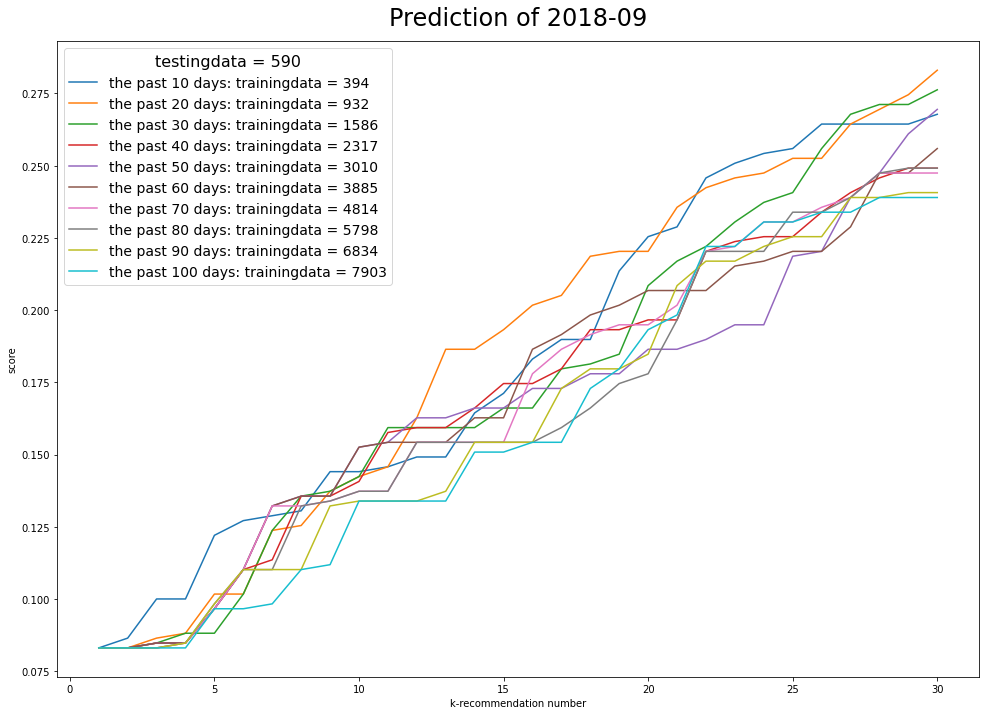

In [222]:
graph(predict=datetime.date(2018,9,1),start=1,period=10)

##Fig 2. 2017年08月為測試資料之評估分數
過去不同天數為訓練資料時，推薦數k對上評估分數的變化。
</br>
觀察k<30範圍內的變化：不同天數為訓練資料時，評估分數變化差異不大；k=10時，各個天數之評估分數分布在1.33至1.77之間，其中以過去50、60、70天為最佳，評估分數為1.775。

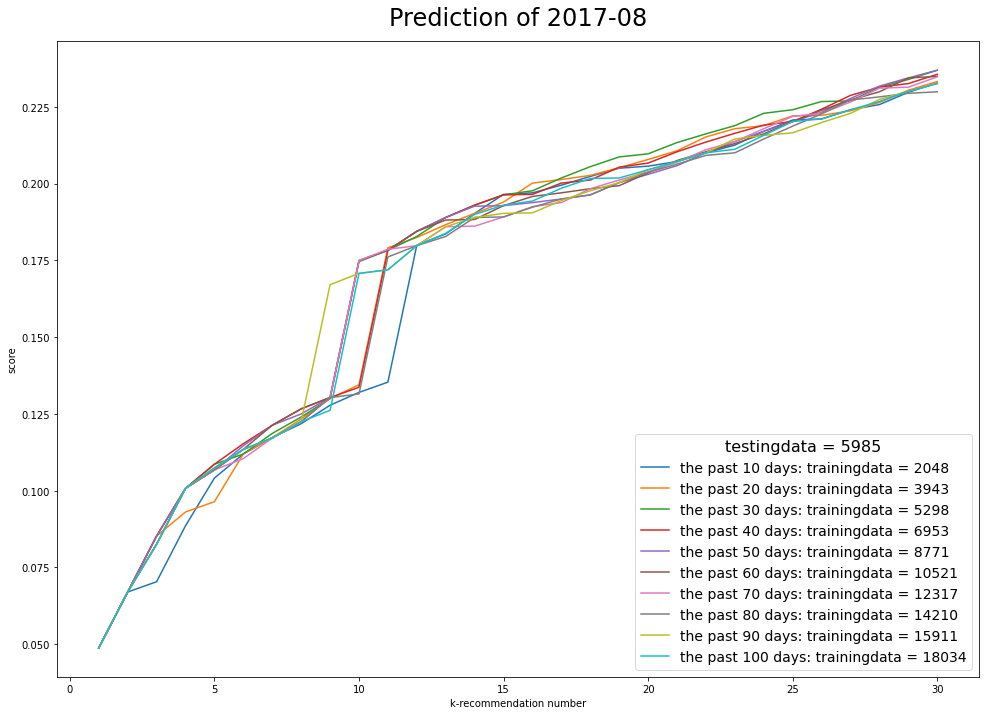

In [223]:
graph(predict=datetime.date(2017,8,1),start=1,period=10,klim=30)

##Fig 3. 2013年04月為測試資料之評估分數

過去不同天數為訓練資料時，推薦數k對上評估分數的變化。
</br>
觀察k<30範圍內的變化：以10、20、30天為訓練資料時，評估分數最差，其餘則差異不大；k=10時，各個天數之評估分數分布在0.95至0.97之間，其中以過去20天為最佳，評估分數為0.990。

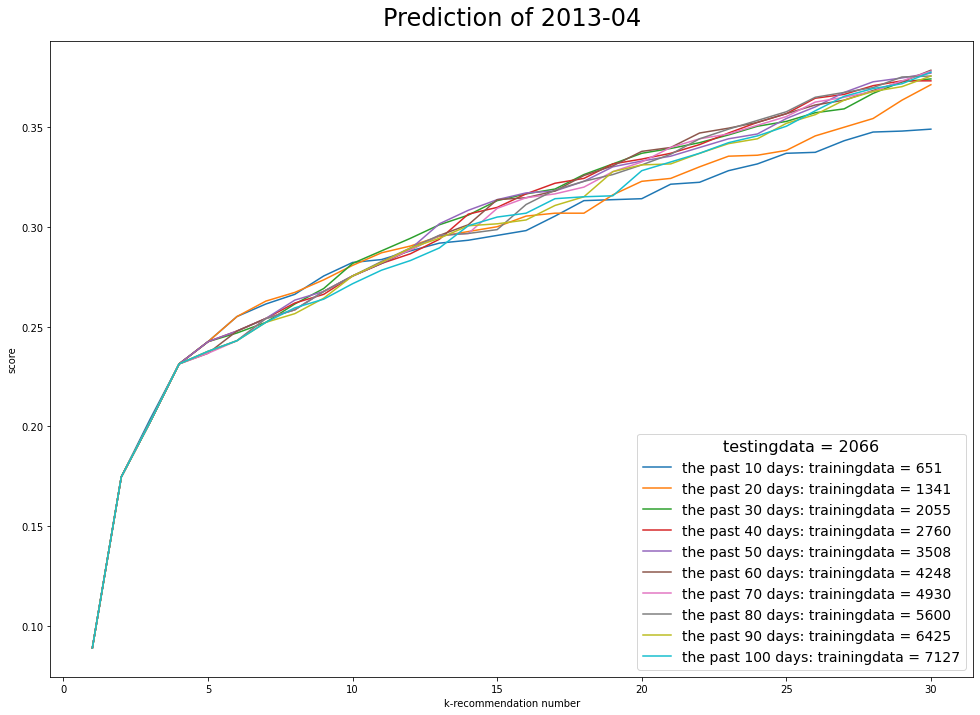

In [224]:
graph(predict=datetime.date(2013,4,1),start=1,period=10,klim=30)

In [225]:
#計算每個月的評價數中，新用戶的評價數

new_reviewer=[]

month=datetime.date(2000,1,1)
count,s=0,set()
start,end=0,0
while month<=datetime.date(2018,9,1):
  while ratings['DATE'].iloc[end]<month+relativedelta(months=1):
    if ratings['reviewerID'].iloc[end] not in s:
      count+=1
    end+=1
  s=set(ratings['reviewerID'].iloc[:end])
  new_reviewer.append(count)
  #new_reviewer.append(len(set(ratings['reviewerID'].iloc[start:end])))
  start=end
  count=0
  month+=relativedelta(months=1)


In [226]:
def var(k=10,start=1,period=10):

  figure, ax = plt.subplots(figsize=(16.53, 11.69))

  for d in range(start,start+10):
    x,y,y1=[],[],[]
    end=datetime.date(2012,1,1)

    while end<=datetime.date(2018,9,1):
      begin=end-relativedelta(days=d*period)
      ratings_trainings,ratings_testings=cut(predict=end)
      ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
      ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
      users = list(ratings_testings_by_user.keys())
      
      t=ratings_trainings[
      (ratings_trainings['DATE'] >= str(begin)) & 
      (ratings_trainings['DATE'] < str(end))
      ]
      
      x.append(end)
      y.append(evaluate(ratings_testings,ratings_testings_by_user, recommender(t, users,k)))
      y1.append(ratings_testings.shape[0])
      end+=relativedelta(months=1)

    ax.plot(x,y,label='the past '+str(d*period)+' days',alpha=0.8)

  ax1 = ax.twinx()
  ax1.plot(x,y1,label='all reviewers',linewidth=5,alpha=0.5)
  new=[n for n in new_reviewer][144:]
  ax1.plot(x,new,label='new reviewers',linewidth=5,alpha=0.5)
  ax1.set_ylabel('number of reviewers',rotation=270)

  #ax2 = ax.twinx()
  #ax2.plot(x,new_reviewer,linewidth=5,alpha=0.3)
  #ax2.set_ylabel('number of testingdata',rotation=270)

  ax.set_xlabel('date')
  ax.set_ylabel('evaluate score')

  h0, l0 = ax.get_legend_handles_labels()
  h1, l1 = ax1.get_legend_handles_labels()
  ax.legend(h0+h1,l0+l1,fontsize=14)
  ax.set_title('Prediction of k = '+str(k),fontsize=24,pad=16)


##Fig 4. 推薦數為10時不同天數對時間的變化

由於2012年以前評論數相對較少，本圖僅處理較有參考價值的2012-2018的數據。
由Fig 1-3 來看，不同天數在不同時間點有不同的結果，然而長遠看來，無論是訓練資料是過去10天還是100天，所有天數的變化趨勢非常接近，因此很難斷定哪個天數能夠適用在所有時間點。
</br>
為了探討什麼參數會造成分數的變化，目前想到可能的變因是當月所有評論數，以及當月新用戶所佔的評論數。
</br>
圖中將上述兩數據以粗線顯示。然而看似沒有一定的規律。唯一可以確定每月新用戶的評論數佔比非常高。

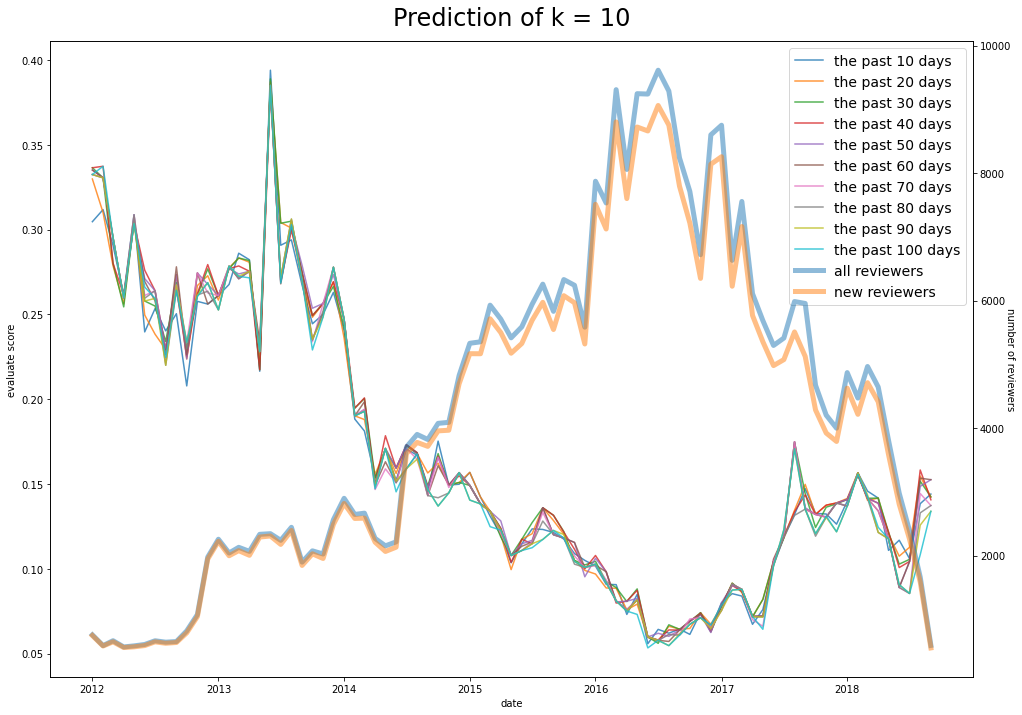

In [227]:
var()